**Table of contents**<a id='toc0_'></a>    
- [Image processing](#toc1_)    
  - [basic image opening](#toc1_1_)    
  - [how to loop thought all files in folder](#toc1_2_)    
  - [transformation and augmentation](#toc1_3_)    
- [CNN architecture](#toc2_)    
  - [Dataloader](#toc2_1_)    
    - [online augmentation](#toc2_1_1_)    
    - [Load data](#toc2_1_2_)    
  - [Model](#toc2_2_)    
    - [custom network](#toc2_2_1_)    
    - [pretrain netweok](#toc2_2_2_)    
- [Training](#toc3_)    
      - [image size 128 100 efnetv2](#toc3_1_1_1_)    
      - [image size 64 50  efnetv2](#toc3_1_1_2_)    
      - [image size 64 50 custom network (this one have val and save impremented)](#toc3_1_1_3_)    
- [Test](#toc4_)    
- [Inference](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Image processing](#toc0_)

In [1]:
import os
from PIL import Image #!pip install pillow
from IPython.display import display
import numpy as np

## <a id='toc1_1_'></a>[basic image opening](#toc0_)

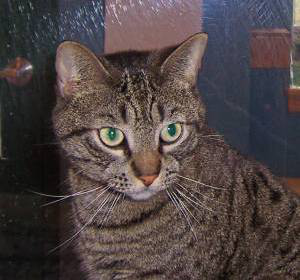

(280, 300, 3)


In [2]:
with Image.open('datasets/cat_dog/cat_dog/train/cat/1.jpg') as my_cat:
    display(my_cat)
    nparray_cat = np.array(my_cat)
    print(nparray_cat.shape)

## <a id='toc1_2_'></a>[how to loop thought all files in folder](#toc0_)

In [3]:
path = "datasets/cat_dog/cat_dog"

img_names = []

for folder,subfolders,filenames in os.walk(path):


    # print(f"{folder} | {subfolders} | {filenames}")
    #write whatever filtering you want - to get the file you want
    for name in filenames:
        img_names.append(folder + '/' + name)
        
len(img_names)

25007

## <a id='toc1_3_'></a>[transformation and augmentation](#toc0_)

* increase data

In [4]:
from torchvision import transforms
import matplotlib.pyplot as plt

In [5]:
transforms.RandomRotation?

Init signature:
transforms.RandomRotation(
    degrees,
    interpolation=<InterpolationMode.NEAREST: 'nearest'>,
    expand=False,
    center=None,
    fill=0,
)
Docstring:     
Rotate the image by angle.
If the image is torch Tensor, it is expected
to have [..., H, W] shape, where ... means an arbitrary number of leading dimensions.

Args:
    degrees (sequence or number): Range of degrees to select from.
        If degrees is a number instead of sequence like (min, max), the range of degrees
        will be (-degrees, +degrees).
    interpolation (InterpolationMode): Desired interpolation enum defined by
        :class:`torchvision.transforms.InterpolationMode`. Default is ``InterpolationMode.NEAREST``.
        If input is Tensor, only ``InterpolationMode.NEAREST``, ``InterpolationMode.BILINEAR`` are supported.
        For backward compatibility integer values (e.g. ``PIL.Image[.Resampling].NEAREST``) are still accepted,
        but deprecated since 0.13 and will be removed in 0.15.

In [6]:
dog = Image.open("datasets/cat_dog/cat_dog/train/dog/14.jpg")

torch.Size([3, 64, 64])


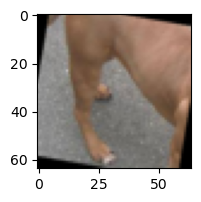

In [7]:
transform = transforms.Compose([
                                transforms.RandomCrop(200),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomRotation(30),


                                transforms.Resize((64)),
                                transforms.ToTensor(),
                                 ])

norm_dog = transform(dog)

print(norm_dog.shape)
plt.figure(figsize = (2,2))
plt.imshow(np.transpose(norm_dog, (1,2,0)))


# <a id='toc2_'></a>[CNN architecture](#toc0_)

In [8]:
import torch
import torch.nn as nn #defining neural network
import torch.nn.functional as F #helper
from torch.utils.data import DataLoader #batching
from torchvision import datasets, transforms #loading datasets
from torchvision.utils import make_grid  #for visualization

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import os

In [9]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU")


GPU is available


In [10]:
torch.manual_seed(96)

## <a id='toc2_1_'></a>[Dataloader](#toc0_)

### <a id='toc2_1_1_'></a>[online augmentation](#toc0_)

In [11]:
# transforms.Resize(128),
# transforms.RandomCrop(100),

train_transform = transforms.Compose([

                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomRotation(30),


                                transforms.Resize(64),
                                transforms.RandomCrop(50),
                                transforms.ToTensor(),
                                 ])

test_transform = transforms.Compose([

                                transforms.Resize(64),
                                transforms.CenterCrop(50),
                                transforms.ToTensor(),
                                ])


torch.Size([3, 50, 50])
torch.Size([3, 50, 50])


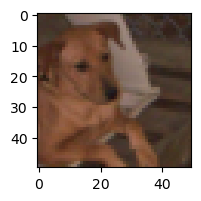

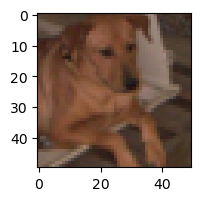

In [12]:
# test
dog = Image.open("datasets/cat_dog/cat_dog/train/dog/100.jpg")
norm_dog = train_transform(dog)
print(norm_dog.shape)
plt.figure(figsize = (2,2))
plt.imshow(np.transpose(norm_dog, (1,2,0)))
norm_dog = test_transform(dog)
print(norm_dog.shape)
plt.figure(figsize = (2,2))
plt.imshow(np.transpose(norm_dog, (1,2,0)))

### <a id='toc2_1_2_'></a>[Load data](#toc0_)

In [13]:
root = "datasets/cat_dog/cat_dog/"

train_data = datasets.ImageFolder(os.path.join(root,'train'),transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(root,"test"),transform=test_transform) 

see inside

In [14]:
len(train_data),len(test_data)

(18002, 6998)

In [15]:
set(train_data.targets),train_data.classes

({0, 1}, ['cat', 'dog'])

In [16]:
np_targets = np.array(train_data.targets)
np_targets

array([0, 0, 0, ..., 1, 1, 1])

In [17]:
print("train label:")
for i,cls in enumerate(train_data.classes):
    print(f"{cls} {len(np_targets[np_targets == i])}") # balanced

train label:
cat 9001
dog 9001


In [18]:
train_set,val_set = torch.utils.data.random_split(train_data,[16002,2000])

In [17]:
arr

NameError: name 'arr' is not defined

Dataloader

In [19]:
# if balance just do normal
train_loader = DataLoader(train_set,batch_size = 64,shuffle=True)
val_loader = DataLoader(val_set,batch_size = 64,shuffle=True)
test_loader = DataLoader(test_data,batch_size = 6998,shuffle=False) # no need to shuffle and batch cuda will not out of memory because no grad cal



In [20]:
# if data not balanced
# do oversamping

import torch
from torch.utils.data import DataLoader, WeightedRandomSampler

np_targets = np.array(train_set.targets)

class_weights = [1/len(np_targets[np_targets == i]) for i in range(len(train_set.classes))]  
sampler = WeightedRandomSampler(class_weights, len(train_set),replacement=True)

train_loader = DataLoader(train_set, batch_size=64, sampler=sampler) # no need to shuffle sampler is shuffle for you

val_loader = DataLoader(val_set,batch_size = 64,shuffle=True)
test_loader = DataLoader(test_data,batch_size = 6998,shuffle=False)


torch.Size([64, 3, 50, 50])
torch.Size([64])


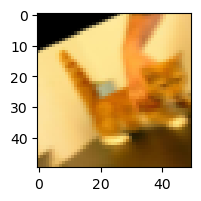

In [21]:
for image, label in train_loader:
    print(image.shape) # (bs,ch,h,w)
    print(label.shape) 

    norm_dog = image[0] # np.transpose(image,(0,1,3,2))
    plt.figure(figsize = (2,2))
    plt.imshow(np.transpose(norm_dog, (1,2,0)))
    
    break

In [ ]:
arr

NameError: name 'arr' is not defined

## <a id='toc2_2_'></a>[Model](#toc0_)

### <a id='toc2_2_1_'></a>[custom network](#toc0_)

In [ ]:
class POOH_CNN(nn.Module):

    """
    everything square because it easy
    conv_lc : [input,filter, ..] => [(chanel,kernal size),..] 
    linear_lc : [node1,node2,...,output] => [num node,..]
    

    example:

    images shape (224,224,3)
    output 2 class

    conv_lc = [(3,224),(6,5),(16,3)]
    linear_lc = [120,84,2]

    
    """

    def __init__(self,conv_lc,linear_lc):
        super().__init__()


        self.conv_list = nn.ModuleList([
                                        nn.Conv2d(conv_lc[i][0],conv_lc[i+1][0],kernel_size=conv_lc[i+1][1] ,stride=1,padding=1) 
                                        for i in range(len(conv_lc[:-1])) 
                                        ])
        
        # calculate output shape of conv part for now it support sride and pad 1
        curr_shape = conv_lc[0][1]
        for c in conv_lc[1:]:
            curr_shape = self.cal_convshape(I = curr_shape,F=c[1])
        self.conv_out = int(conv_lc[-1][0]*curr_shape**2)
        linear_lc = [self.conv_out]+linear_lc

        self.linear_list = nn.ModuleList([
                                        nn.Linear(linear_lc[i],linear_lc[i+1])
                                          for i in range(len(linear_lc[:-1]))
                                          ])

    def cal_convshape(self,I,F,P=1,S=1):
        return ((I-F+2*P)/S)+1
    
    def cal_pad(self,F,S):
        pass

    def forward(self,images):
        
        output = images
        for layer in self.conv_list:
            output = F.relu(layer(output))

        output = output.reshape(-1,self.conv_out)
        for layer in self.linear_list[:-1]:
            output = F.relu(layer(output))

        output = self.linear_list[-1](output)
        # no need to use softmax because we will use CrossEnteropy Loss which includes a softmax operation internally.
        
        return output







In [ ]:
param = {"conv_lc":[(image.shape[1],image.shape[2]),(6,5),(16,3)],"linear_lc":[120,84,len(train_data.classes)]}

model = POOH_CNN(**param)

In [ ]:
model.conv_list

ModuleList(
  (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [ ]:
model.linear_list

ModuleList(
  (0): Linear(in_features=36864, out_features=120, bias=True)
  (1): Linear(in_features=120, out_features=84, bias=True)
  (2): Linear(in_features=84, out_features=2, bias=True)
)

In [ ]:
model

POOH_CNN(
  (conv_list): ModuleList(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (linear_list): ModuleList(
    (0): Linear(in_features=36864, out_features=120, bias=True)
    (1): Linear(in_features=120, out_features=84, bias=True)
    (2): Linear(in_features=84, out_features=2, bias=True)
  )
)

In [ ]:
# test
output  = model(image)
output.shape

assert output.shape[1] == 2

In [ ]:
arr

NameError: name 'arr' is not defined

### <a id='toc2_2_2_'></a>[pretrain netweok](#toc0_)

In [ ]:
from torchvision import models

In [ ]:
efnetv2 = models.efficientnet_v2_s(weights=models.efficientnet.EfficientNet_V2_S_Weights.IMAGENET1K_V1)
# alexnet = models.alexnet(weights = models.AlexNet_Weights.DEFAULT)

In [ ]:
efnetv2

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [ ]:
# freeze 
for param in efnetv2.parameters():
    param.requires_grad = False


In [ ]:
# modify class
efnetv2.classifier = nn.Sequential(
    nn.Linear(in_features=1280, out_features=1000, bias=True),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(1000, 2)
)

# alexnet.classifier = nn.Sequential(
#     nn.Linear(in_features=9216, out_features=1024),
#     nn.ReLU(),
#     nn.Dropout(0.4),
#     nn.Linear(1024, 2)
# )

In [ ]:
efnetv2

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [ ]:
model = efnetv2

In [ ]:
arr

NameError: name 'arr' is not defined

# <a id='toc3_'></a>[Training](#toc0_)

#### <a id='toc3_1_1_1_'></a>[image size 128 100 efnetv2](#toc0_)

In [ ]:
criterion = nn.CrossEntropyLoss()
optim     = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [ ]:
num_epochs = 5

for i in range(num_epochs):
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        y_hat = model(images)
        loss = criterion(y_hat, labels)

        optim.zero_grad()
        loss.backward()
        optim.step()

        total_loss += loss.item()
        total_correct += (torch.max(y_hat, 1)[1] == labels).sum().item()
        total_samples += len(images)

    epoch_loss = total_loss / len(train_loader)
    epoch_acc = (total_correct / total_samples) * 100

    print(f"Epoch: {i} | Train acc: {epoch_acc:3.2f} | Loss: {epoch_loss:3.4f}")


Epoch: 0 | Train acc: 91.68 | Loss: 0.1989
Epoch: 1 | Train acc: 94.63 | Loss: 0.1353
Epoch: 2 | Train acc: 95.05 | Loss: 0.1281
Epoch: 3 | Train acc: 95.31 | Loss: 0.1176
Epoch: 4 | Train acc: 95.68 | Loss: 0.1159


In [ ]:
arr

NameError: name 'arr' is not defined

#### <a id='toc3_1_1_2_'></a>[image size 64 50  efnetv2](#toc0_)

In [ ]:
criterion = nn.CrossEntropyLoss()
optim     = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [ ]:
num_epochs = 5

for i in range(num_epochs):
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        y_hat = model(images)
        loss = criterion(y_hat, labels)

        optim.zero_grad()
        loss.backward()
        optim.step()

        total_loss += loss.item()
        total_correct += (torch.max(y_hat, 1)[1] == labels).sum().item()
        total_samples += len(images)

    epoch_loss = total_loss / len(train_loader)
    epoch_acc = (total_correct / total_samples) * 100

    print(f"Epoch: {i} | Train acc: {epoch_acc:3.2f} | Loss: {epoch_loss:3.4f}")


Epoch: 0 | Train acc: 83.66 | Loss: 0.3652
Epoch: 1 | Train acc: 89.48 | Loss: 0.2558
Epoch: 2 | Train acc: 89.46 | Loss: 0.2585
Epoch: 3 | Train acc: 90.88 | Loss: 0.2217
Epoch: 4 | Train acc: 92.16 | Loss: 0.2126


In [ ]:
arr

NameError: name 'arr' is not defined

#### <a id='toc3_1_1_3_'></a>[image size 64 50 custom network (this one have val and save impremented)](#toc0_)

In [ ]:
criterion = nn.CrossEntropyLoss()
optim     = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
model.to(device)

POOH_CNN(
  (conv_list): ModuleList(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (linear_list): ModuleList(
    (0): Linear(in_features=36864, out_features=120, bias=True)
    (1): Linear(in_features=120, out_features=84, bias=True)
    (2): Linear(in_features=84, out_features=2, bias=True)
  )
)

In [ ]:
import os
from pathlib import Path


file_path = "models/cnn/cat_dog"

if not os.path.exists(file_path):
    os.makedirs(file_path,exist_ok=True)

save_path = Path(file_path,"cat_dog_last.pth")
check_path = Path(file_path,"cat_dog_best.pth")


In [ ]:
import pickle
# for custom model
data_path = Path(file_path,"data.json")

data = {"param":param,
        "cls":train_data.classes}

with open(data_path,"wb") as file:
    pickle.dump(data,file)


In [ ]:
num_epochs = 5
show_epoch = 1
best_val = np.inf

for i in range(num_epochs):

    train_loss = 0.0
    train_correct = 0
    train_samples = 0

    val_loss = 0.0
    val_correct = 0
    val_samples = 0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        y_hat = model(images)
        loss = criterion(y_hat, labels)

        optim.zero_grad()
        loss.backward()
        optim.step()

        train_loss += loss.item()
        train_correct += (torch.max(y_hat, 1)[1] == labels).sum().item()
        train_samples += len(images)

    for images,labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        y_hat = model(images)
        loss = criterion(y_hat,labels)

        val_loss += loss.item()
        val_correct += (torch.max(y_hat, 1)[1] == labels).sum().item()
        val_samples += len(images)

    epoch_train_loss = train_loss / len(train_loader)
    epoch_train_acc = (train_correct / train_samples) * 100

    epoch_val_loss = val_loss / len(val_loader)
    epoch_val_acc = (val_correct / val_samples) * 100

    if epoch_val_loss < best_val:
        best_val = epoch_val_loss
        torch.save(model.state_dict(),check_path)

    if i%show_epoch == show_epoch-1:

        print(f"Epoch: {i+1} | Train acc: {epoch_train_acc:3.2f} | Train Loss: {epoch_train_loss:3.4f} | val acc: {epoch_val_acc:3.2f} | val Loss: {epoch_val_loss:3.4f}")

print(f"Best Val Loss: {best_val:3.4f}")
torch.save(model.state_dict(),save_path)

Epoch: 1 | Train acc: 55.18 | Train Loss: 0.6843 | val acc: 53.25 | val Loss: 0.6932
Epoch: 2 | Train acc: 59.89 | Train Loss: 0.6650 | val acc: 55.75 | val Loss: 0.6937
Epoch: 3 | Train acc: 61.54 | Train Loss: 0.6576 | val acc: 63.70 | val Loss: 0.6432
Epoch: 4 | Train acc: 58.99 | Train Loss: 0.6673 | val acc: 65.05 | val Loss: 0.6375
Epoch: 5 | Train acc: 64.65 | Train Loss: 0.6325 | val acc: 64.75 | val Loss: 0.6267
Best Val Loss: 0.6267


In [ ]:
arr

NameError: name 'arr' is not defined

# <a id='toc4_'></a>[Test](#toc0_)

In [ ]:
device = torch.device("cpu")
model.to(device)
model.eval() # to set dropout and batch normalization layers to evaluation mode if you want to train use model.train

POOH_CNN(
  (conv_list): ModuleList(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (linear_list): ModuleList(
    (0): Linear(in_features=36864, out_features=120, bias=True)
    (1): Linear(in_features=120, out_features=84, bias=True)
    (2): Linear(in_features=84, out_features=2, bias=True)
  )
)

In [ ]:
test_loss = 0.0
test_correct = 0
test_samples = 0


with torch.no_grad(): # this will turn off gradient calculations so it will be faster
    for images, labels in test_loader:
        y_hat = model(images)
        loss = criterion(y_hat,labels)

        test_loss += loss.item()
        y_hat_pred =  torch.max(y_hat, 1)[1]
        test_correct += (y_hat_pred == labels).sum().item()
        test_samples += len(images)

    
print(f"Test | Accuacy: {(test_correct / test_samples) * 100:3.2f} | Loss: {test_loss / len(test_loader)}")
    


Test | Accuacy: 67.18 | Loss: 0.5991517901420593


In [ ]:
y_hat_pred =  torch.max(y_hat, 1)[1]
y_hat_pred.shape

torch.Size([6998])

In [ ]:
confusion_matrix(y_hat_pred, labels)

array([[2837, 1635],
       [ 662, 1864]], dtype=int64)

# <a id='toc5_'></a>[Inference](#toc0_)

In [ ]:
import pickle
from my_models import POOH_CNN
import torch

# load model

data_path = "models/cnn/cat_dog/data.json"
check_path = "models/cnn/cat_dog/cat_dog_best.pth"

with open(data_path,"rb") as file:
    data = pickle.load(file)

param =data["param"]
cls = data["cls"]
model = POOH_CNN(**param)
model.load_state_dict(torch.load(check_path))
model.eval()


POOH_CNN(
  (conv_list): ModuleList(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (linear_list): ModuleList(
    (0): Linear(in_features=36864, out_features=120, bias=True)
    (1): Linear(in_features=120, out_features=84, bias=True)
    (2): Linear(in_features=84, out_features=2, bias=True)
  )
)

In [ ]:
# define tranform
from torchvision import transforms

transform = transforms.Compose([

                                transforms.Resize(64),
                                transforms.CenterCrop(50),
                                transforms.ToTensor(),
                                ])


predict: dog


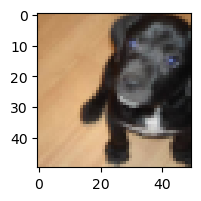

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

dog = Image.open("datasets/cat_dog/cat_dog/train/dog/112.jpg")

norm_dog = transform(dog)

y_hat = model(norm_dog)
y_hat_pred =  torch.max(y_hat, 1)[1]

print(f"predict: {cls[y_hat_pred]}")
plt.figure(figsize = (2,2))
plt.imshow(np.transpose(norm_dog, (1,2,0)))

check if it really the same (have to run test loader above)

In [20]:
from torch import nn

criterion = nn.CrossEntropyLoss()


with torch.no_grad(): 
    for images, labels in test_loader:
        y_hat = model(images)
        loss = criterion(y_hat,labels)

        test_loss = loss.item()
        y_hat_pred =  torch.max(y_hat, 1)[1]
        test_correct = (y_hat_pred == labels).sum().item()
        test_samples = len(images)

    
print(f"Test | Accuacy: {(test_correct / test_samples) * 100:3.2f} | Loss: {test_loss / len(test_loader)}")
    


Test | Accuacy: 67.18 | Loss: 0.5991517901420593
